## Application: Peak Deconvolution
<hr style="height: 3.0px"/>

:::{admonition} Learning Objectives   
After completing this lesson, you should be able to:  
* load cal() and selectdata() functions from our utilities notebook using `%run getpix_utilities.ipynb`  
* install a new package for more advanced fitting procedures: `lmfit`  
* analyze the data found in *Cystallization Kinetics of an ionic liquid (Royal Society of Chemistry Advances >(RSC Adv.), 2014, vol. 4, p. 22277)*  
* fit (deconvolution) of two overlapping peaks in calorimetry data   
* recognize that literature papers can often contain mistakes.  
:::

This lesson will pull data from the literature using the digitizing functions (`selectdata()`, `cal()`) that we created previously and saved in a utilities file called `getpix_utilities.ipynb`.  We load this notebook as we did in the last lesson by using `%run getpix_utilities.ipynb`.  We can't use our import method since these functions have interactive content. 

Much of this lesson is borrowed from the more extensive treatment in [**"Peak fitting XRD data with Python" by Chris Ostrouchov**](https://chrisostrouchov.com/post/peak_fit_xrd_python/)

The first thing you need to do is install the new package "lmfit" as explained in the short video below which can also be found at [https://youtu.be/R8FX2G8m6XM](https://youtu.be/R8FX2G8m6XM).  If you would prefer to read about lmfit you can find that info here: [https://lmfit.github.io/lmfit-py/](https://lmfit.github.io/lmfit-py/).  

For the impatient, just type `pip install lmfit` at your command prompt.  

In [2]:
from IPython.display import HTML, IFrame
# Youtube
#HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/R8FX2G8m6XM?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')
IFrame("https://www.youtube.com/embed/R8FX2G8m6XM",870*0.8,613*0.8)

**Download:**  [getpix_utilities.ipynb](https://drive.google.com/uc?export=download&id=1lrKrd5tqYUn88Cfh8_ntL4o8lAZTjmHG) and place in the same folder as the notebook you are loading this file into.  

In [2]:
%run getpix_utilities.ipynb

Help on function cal in module __main__:

cal(pixpts, plotpts, datatoconvert)
    pixpts = list of three pixel points (typically along axes)
    plotpts = list of three points corresponding to pixpts but in plot units
    datatoconvert = list of pixel points to convert to plot coordinates

Help on function selectdata in module __main__:

selectdata(path_to_image_file, fig_size_as_tuple=(6, 6))
    path_to_image_file example: r"C:/Users/Sean/images/xrd data.png"  
    pixel data stored in global variable "pixel_positions"
    fig_size_as_tuple e.g. (8,12) This adjusts the image size shown.



In [3]:
########  The lmfit import will not work until you install lmfit as described above. 

# import os
import math
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from scipy import optimize, signal

from lmfit import models, Model, Parameters

Let's generate some overlapping peak data representing for example, Differential Scanning Calorimetry (DSC) data.  The presence of a peak indicates the formation of crystals within the polymer.  Overlapping peaks correspond to two different crystalline structures forming.  

DSC will be discussed in MSE 4554 polymer engineering.  The kinetics of crystalization as we saw in the previous chapter often follows the Avrami equation, $Y=1-e^{-K t^n}$.

For the sake of generating some overlapping peak data, we are going to use a simple gaussian peak function.  For homework, you will perform the fitting routines that we will be discussing for real DSC data.  The idea here is learn how to fit overlapping peaks with "ideal" data and then you can apply this to real data.    

Recall the Gaussian function is given by $f(x;A,\mu,\sigma)=\frac{A}{\sigma \sqrt{2\pi}}e^{-(x-\mu)^2/\ (2 \sigma^2)}$

In [4]:
# Writing the above as a function: 
def g(x, A, μ, σ):
    return A/(σ*np.sqrt(2*np.pi)) * np.exp(-1/2*((x - μ) / σ)**2)
# A is referred to as the amplitude but really the amplitude depends on A/σ
# μ is the peak position mean 
# σ is the standard deviation

:::{Hint}
You can use greek letters for variable names.  For example to get $\sigma$ in a code cell, type `\sigma` and then *press the tab key*. 
:::

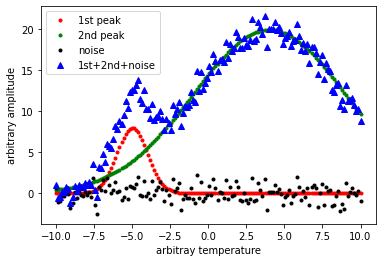

In [5]:
# here we define the parameters [A,μ,σ] for the two peaks
g_0 = [250.0, 4.0, 5.0] # [A,μ,σ] peak centered at 4
g_1 = [20.0, -5.0, 1.0] # [A,μ,σ] peak centered at -5
n = 150 # number of points
x = np.linspace(-10, 10, n) #generate our x data
noise=np.random.randn(n) #generate some noise to add to our points
y = g(x, *g_0) + g(x, *g_1) + noise #generating some data with random noise
# the star operator used in the above line is discussed below

plt.plot(x, g(x, *g_1), 'r.', label='1st peak'); #peak at -5
plt.plot(x, g(x, *g_0), 'g.', label='2nd peak'); #peak at 4
plt.plot(x, noise, 'k.', label='noise'); #noise
plt.plot(x, y, 'b^', label='1st+2nd+noise'); #sum of the above
plt.ylabel('arbitrary amplitude');
plt.xlabel('arbitray temperature');
plt.legend()
plt.show()

:::{note}
What we would like to do is take the blue triangle points generated above and see if we can fit this noisy data to get back the two red peaks.  
:::

I used the star operator above for example \*g_0 as a shortcut.  The above \*g_0 places the values 250.0, 4.0, 5.0 into our function call **without** the square brackets.  Remember our function, $g(x, A, \mu, \sigma)$, is looking for a total of 4 separate values.  The following are equivalent: 
```Python
g(x, *g_0) or 
g(x, g_0[0], g_0[1], g_0[2])
g(x, 250.0, 4.0, 5.0)  
```

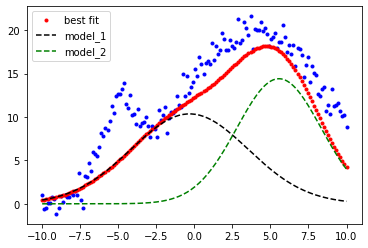

{'m2_A': 99.99999980249072, 'm2_μ': 5.5595893942688654, 'm2_σ': 2.767372177378241, 'm1_A': 100.0, 'm1_μ': -0.3152139732438844, 'm1_σ': 3.849820246230684}


In [8]:
# Let's fit our x,y data from above
xdata=x #from above
ydata=y #from above

# the model (peak function) we are using is the gaussian function
# which we defined previously g(x,A,μ,σ)

# define two models. One for each peak.  
model_1 = Model(g, prefix='m1_') # g is the gaussian function we defined previously
model_2 = Model(g, prefix='m2_') # using the same function but changing prefix
model = model_1 + model_2 # our fitting model is the sum of the two

# the prefix used above changes the variable names so that the variables are
# different in each peak for example, the new variable names become: 
# m1_A, m2_A, m1_σ, m2_σ, and so on...  

# now we help the fitting process by giving starting values and bounds on our parameters
params = Parameters()
# parameters given as: (NAME, VALUE, VARY?, MIN,  MAX,  EXPR,  BRUTE_STEP)
params.add_many(('m1_A', 3, True, 0, 100, None, None),
                ('m1_μ', 5, True, None, None, None, None),
                ('m1_σ', 1, True, None, None, None, None),
                ('m2_A', 1, True, 0, 100, None, None),
                ('m2_μ', -3, True, None, None, None, None),
                ('m2_σ', 1, True, None, None, None, None))

result = model.fit(ydata, params, x=xdata) #now we perform the fit to our x & y data with the given params
comps = result.eval_components() #this separates the results into the two components model_1 and model_2

plt.plot(xdata, ydata, 'b.') #our x,y data blue dots
plt.plot(xdata, result.best_fit, 'r.', label='best fit') # our overall fit red line
plt.plot(xdata, comps['m1_'], 'k--', label='model_1') # peak 1 fit black dashed
plt.plot(xdata, comps['m2_'], 'g--', label='model_2') # peak 2 fit green dashed
plt.legend(loc='best')
plt.show()

#print(result.fit_report())
print(result.best_values)


In [15]:
# try running this code to all the information that is available for the fit
# print(result.fit_report())

**That fit (red points) is not looking very good.** I tried to "help" the fitting routine by confining the $A$ values to a min and max of 0 and 100 but I forgot that the amplitude of the gaussian is related to the ratio of $A/\sigma$. Let's remove the constraints on the maximum values and try again.  

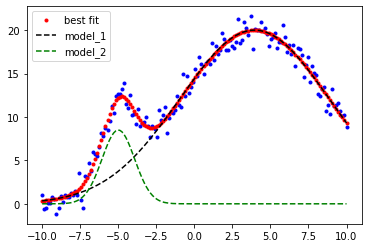

{'m2_A': 22.89345056794308, 'm2_μ': -4.995592775230127, 'm2_σ': 1.0742981679921704, 'm1_A': 245.395752300964, 'm1_μ': 3.9529577793485005, 'm1_σ': 4.891676712677183}


In [12]:
# now we help the fitting process by giving starting values and bounds on our parameters
params = Parameters()
# parameters given as: (NAME, VALUE, VARY?, MIN,  MAX,  EXPR,  BRUTE_STEP)
params.add_many(('m1_A', 3, True, 0, None, None, None),
                ('m1_μ', 5, True, None, None, None, None),
                ('m1_σ', 1, True, None, None, None, None),
                ('m2_A', 1, True, 0, None, None, None),
                ('m2_μ', -3, True, None, None, None, None),
                ('m2_σ', 1, True, None, None, None, None))

result = model.fit(ydata, params, x=xdata) #now we perform the fit to our x & y data with the given params
comps = result.eval_components() #this separates the results into the two components model_1 and model_2

plt.plot(xdata, ydata, 'b.') #our x,y data blue dots
plt.plot(xdata, result.best_fit, 'r.', label='best fit') # our overall fit red line
plt.plot(xdata, comps['m1_'], 'k--', label='model_1') # peak 1 fit black dashed
plt.plot(xdata, comps['m2_'], 'g--', label='model_2') # peak 2 fit green dashed
plt.legend(loc='best')
plt.show()

#print(result.fit_report())
print(result.best_values)

**Much better!**

Comparing our fit parameters to the exact values looks pretty good! 

```python
exact values peak 2: [250.0, 4.0, 5.0];  fit values: [245.4, 3.95, 4.89]
exact values peak 1: [20.0, -5.0, 1.0];  fit values: [22.9, -4.996, 1.07]
```

**Now we have a nice fit!**

Notice above in the plot commands that:  
The x-values are given by `xdata` for all plots and  
`result.best_fit` gives the y-values for the overall fit (red points)  
<br>
Now recall we made 2 Models: `Model(g, prefix='m1_')` and `Model(g, prefix='m2_')` so we can also get the results for each individual model (peaks in our case) by first:  `comps = result.eval_components()` then using the defined prefixes we get the single peak fits by:  
<br>
`comps['m1_']`    gives the y-values for the model 1 peak  
`comps['m2_']`    gives the y-values for the model 2 peak  


In [30]:
# # run each of the commands below to see what you get
# # you will need to uncomment them one at a time to see the output
# # unless you uncomment and wrap each with a print() statement

# result.eval_components()
# result.best_fit
# result.best_values
# result.best_values['m2_μ']
# result.best_values.values()
# print(result.fit_report())
# result

**Let's look at how to use our fit parameters to plot the gaussian function.**

In [44]:
vals=result.best_values
vals

{'m2_A': 22.89345056794308,
 'm2_μ': -4.995592775230127,
 'm2_σ': 1.0742981679921704,
 'm1_A': 245.395752300964,
 'm1_μ': 3.9529577793485005,
 'm1_σ': 4.891676712677183}

recall our definition for the gaussian function:  
```python
def g(x, A, μ, σ):
    return A/(σ*np.sqrt(2*np.pi)) * np.exp(-1/2*((x - μ) / σ)**2)
```

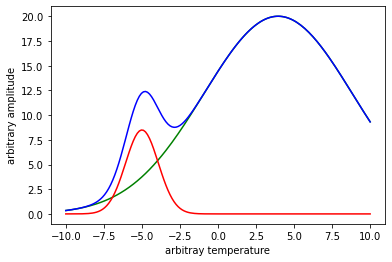

In [45]:
n = 150 # number of points
x = np.linspace(-10, 10, n) #generate our x data
# recall our function g() has 4 params in this order g(x, A, μ, σ)
y1=g(x, vals['m1_A'], vals['m1_μ'],vals['m1_σ']) 
y2=g(x, vals['m2_A'], vals['m2_μ'],vals['m2_σ'])
ysum= y1+y2

plt.plot(x, y1, 'g-'); 
plt.plot(x, y2, 'r-'); 
plt.plot(x, ysum, 'b-'); 
plt.ylabel('arbitrary amplitude');
plt.xlabel('arbitray temperature');

Compare the fitted peaks to the exact peaks used in the beginning to generate our noisy data.  

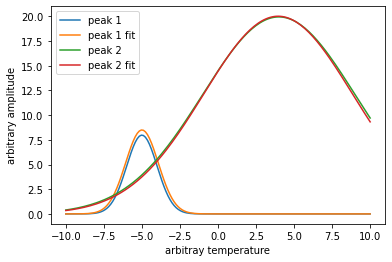

In [67]:
n = 150 # number of points
x = np.linspace(-10, 10, n) #generate our x data
# recall our function g() has 4 params in this order g(x, A, μ, σ)

y1=g(x,20.0, -5.0, 1.0)
y1_fit=g(x, vals['m2_A'], vals['m2_μ'],vals['m2_σ'])
y2=g(x,250.0, 4.0, 5.0)
y2_fit=g(x, vals['m1_A'], vals['m1_μ'],vals['m1_σ']) 

plt.plot(x,y1,x,y1_fit,x,y2,x,y2_fit)
plt.legend(['peak 1','peak 1 fit','peak 2','peak 2 fit'])
plt.ylabel('arbitrary amplitude');
plt.xlabel('arbitray temperature');

The fit looks pretty good especially considering how much noise we put into our original data.    

## Exercises

The data for the exercises below were taken from: 

:::{image} ../images/10_crystallization_paper.png
:width: 600px
:align: center
:::

<img alt="" src="../images/10_crystallization_paper.png" width=600px>

:::{Admonition} Helpful summary of variables used Problems 1-4. 
Data from image: 
* dsc_data -- overall curve from image  
* p1_author_data -- data defining authors's fit for peak 1  
* p2_author_data -- data defining authors's fit for peak 2  
<br>
Fits:
* fit_dsc -- fit of dsc_data from image
    * fit_dsc_peak_1 -- peak 1 from our overall fit_dsc (.eval_components()['m1_'])
    * fit_dsc_peak_2 -- peak 2 from our overall fit_dsc (.eval_components()['m2_'])
* fit_p1_author -- fit of p1_author_data from image
* fit_p2_author -- fit of p2_author_data from image
* (fit_p1_author + fit_p2_author) -- gives authors' overall fit to dsc_data
:::

### Problem 1:

Reproduce all three data curves shown below. The thick green line (overall curve) is the measured data from DSC. After conversion to plot scale, name this data set, **"dsc_data"**.  The peaks labeled $P_1$ and $P_2$ are fitted curves determined by the authors. Let's call these **"p1_author_data"** and **"p2_author_data"**. Plot your data for all three peaks, include labels for the x,y axes.  

:::{image} ../images/10_prob_1_fig.png
:width: 600px
:align: center
:::

<img alt="DSC data" src="../images/10_prob_1_fig.png" width=600px>

### Problem 3

Fit the three data sets that you obtained from problem 1 (dsc_data, p1_author_data, and p2_author_data) using a Gaussian function as in the lesson. Label your fitted results **fit_dsc**, **fit_p1_author** and **fit_p2_author** respectively. *Important: use the same x-values for all your fits something like np.linspace(25, 800, 150) should work well.*    

:::{hint}
The fit to dsc_data will require two gaussian peaks (two Models()) as performed in the lesson. Don't forget to change the initial guess for the peak positions, $m1\_\mu$ and $m2\_\mu$.  The fits to the p1_author_data and p2_auth_data only require a single peak (one Model()). You don't need to define a prefix in this case but it is fine if you do.    
:::

Your fitting results for the dsc_data will be composed of two components (e.g. `result.eval_components()['m1_']` and `result.eval_components()['m2_'])` and an overall result, `result.best_fit`. Assign these to variables: **fit_dsc_peak_1, fit_dsc_peak_2,** and **fit_dsc**.  

**Evaluate your fits visually**
<br>
In one plot, plot dsc_data (as points) and your overall best fit i.e. fit_dsc (as lines, no marker).  
<br>
In another plot, plot p1_author_data (as points), fit_p1_author (lines, no points), p2_author_data (as points), fit_p2_author (lines, no points).  
<br>
Hopefully, you got some nice fits.  

### Problem 3

**(a)** How does your fit compare to the authors fit?  The authors didn't show their overall fit but they did show the two components (peak functions) of their fit which you reproduced as (p1_author_data and p2_author_data).  Let's compare the authors' p1, p2 to your p1, p2 components by plotting on one plot: p1_author_data, p2_author_data, fit_dsc_peak_1, fit_dsc_peak_2.  How do your results compare to the authors?  
<br>
**(b)** From (a) we can see that our result is quite different from the authors. From problem 2, you already saw that your overall fit represents the data quite well. Let's see how the authors overall fit represents the data.  Plot on one plot, dsc_data, fit_dsc, and the sum (fit_p1_author + fit_p2_author).  Use lines, no points for all data sets.  What can you say comparing (by eye) the authors fit vs your fit?   
<br>
**(c)** The two peaks represent the crystallization of two different phases in this material. If the area under the curves P1 and P2 represent the relative amounts of each phase, do your results suggest an increase or decrease in the relative amount of P1/P2 as compared to the authors result. You do not need to calculate anything here.  Just eyeball it. 

### Problem 4

Now there really isn't any reason to assume a gaussian profile for the DSC data as the authors in this paper and many in the literature commonly do.  In fact, we expect the kinetics of crystallization to follow avrami kinetics.  These are the "S" shaped curves we looked at in the last lesson. The avrami curve has the form $Y=1-e^{-K\ t^n}$. 

The peak in the DSC data should just be the derivative of the avrami equation with respect to time which is $$Y'= k n t^{n-1} e^{-k t^n}$$.  

The above equation is given in normalized form below, i.e. the height = 1 and peak position = 1

$$Y'(normalized) = e^{-\frac{(n-1) \left(t^n-1\right)}{n}} t^{n-1}$$

So to fit to an arbitrary amplitude, A, and peak position, B we could write: 

$$\text{A } e^{-\frac{(\text{n}-1) \left(\left(\frac{t}{\text{B}}\right)^{\text{n}}-1\right)}{\text{n}}} \left(\frac{t}{\text{B}}\right)^{\text{n}-1}$$
<br>
Let's now write this as a function called pAvram()

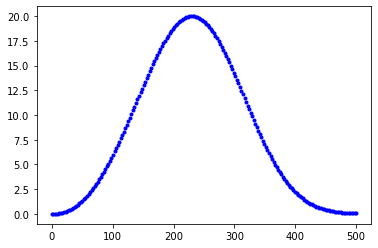

In [214]:
# Avrami peak function as derived above: 
# where A = amplitude, B = peak position, n = avrami fitting parameter
def pAvram(x, A, B, n):
    return A*((x/B)**(n-1))*np.exp(-((n-1)*(((x/B)**n)-1))/n)

x=np.linspace(0, 500, 200)
y=pAvram(x,20,230,3.23)

plt.plot(x, y, 'b.');

(a) Refit the dsc_data now using the pAvram function we defined above.
(b) Plot on one plot: dsc_data, fit_dsc, the sum (fit_p1_author + fit_p2_author), and the overall fit you found from part (a).  Which fit is the best by eye? Use small points for the dsc_data and lines for everything else.  